In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
reconstruction_ZF_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilled/reconstructions/'
reconstruction_ZF_noACS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilledNoACS/reconstructions/'
reconstruction_grappa_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Grappa/reconstructions/'
reconstruction_sense_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Sense/reconstructions/'
reconstruction_CS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/CS/reconstructions/'
reconstruction_ZF_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch47/reconstructions_regularized/'
reconstruction_ZF_unet_noACS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNetSenseMask/Epoch48/reconstructions_regularized/'
reconstruction_grappa_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/GrappaUNet/Epoch48/reconstructions_regularized/'
reconstruction_sense_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/SenseUNet/Epoch48/reconstructions/'
reconstruction_cs_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/CSUNet/Epoch49/reconstructions/'

file = 'file_brain_AXFLAIR_210_6001949.h5'  # R = 4 (global 74th-75th percentile)
slice = 3

GT_path = os.path.join(GT_path,file)
reconstruction_ZF_path = os.path.join(reconstruction_ZF_path,file)
reconstruction_ZF_noACS_path = os.path.join(reconstruction_ZF_noACS_path,file)
reconstruction_grappa_path = os.path.join(reconstruction_grappa_path,file)
reconstruction_sense_path = os.path.join(reconstruction_sense_path,file)
reconstruction_CS_path = os.path.join(reconstruction_CS_path,file)
reconstruction_ZF_unet_path = os.path.join(reconstruction_ZF_unet_path,file)
reconstruction_ZF_unet_noACS_path = os.path.join(reconstruction_ZF_unet_noACS_path,file)
reconstruction_grappa_unet_path = os.path.join(reconstruction_grappa_unet_path,file)
reconstruction_sense_unet_path = os.path.join(reconstruction_sense_unet_path,file)
reconstruction_cs_unet_path = os.path.join(reconstruction_cs_unet_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction_ZF = h5py.File(reconstruction_ZF_path, 'r')
reconstruction_ZF_noACS = h5py.File(reconstruction_ZF_noACS_path, 'r')
reconstruction_grappa = h5py.File(reconstruction_grappa_path, 'r')
reconstruction_sense = h5py.File(reconstruction_sense_path, 'r')
reconstruction_CS = h5py.File(reconstruction_CS_path, 'r')
reconstruction_ZF_unet = h5py.File(reconstruction_ZF_unet_path, 'r')
reconstruction_ZF_unet_noACS = h5py.File(reconstruction_ZF_unet_noACS_path, 'r')
reconstruction_grappa_unet = h5py.File(reconstruction_grappa_unet_path, 'r')
reconstruction_sense_unet = h5py.File(reconstruction_sense_unet_path, 'r')
reconstruction_cs_unet = h5py.File(reconstruction_cs_unet_path, 'r')


In [2]:
GT = GT['reconstruction_rss']
reconstruction_ZF = reconstruction_ZF['reconstruction']
reconstruction_ZF_noACS = reconstruction_ZF_noACS['reconstruction']
reconstruction_grappa = reconstruction_grappa['reconstruction']
reconstruction_sense = reconstruction_sense['reconstruction']
reconstruction_CS = reconstruction_CS['reconstruction']
reconstruction_ZF_unet = reconstruction_ZF_unet['reconstruction']
reconstruction_ZF_unet_noACS = reconstruction_ZF_unet_noACS['reconstruction']
reconstruction_grappa_unet = reconstruction_grappa_unet['reconstruction']
reconstruction_sense_unet = reconstruction_sense_unet['reconstruction']
reconstruction_cs_unet = reconstruction_cs_unet['reconstruction']


In [3]:
GT = np.array(GT)
reconstruction_ZF = np.array(reconstruction_ZF)
reconstruction_ZF_noACS = np.array(reconstruction_ZF_noACS)
reconstruction_grappa = np.array(reconstruction_grappa)
reconstruction_sense = np.array(reconstruction_sense)
reconstruction_CS = np.array(reconstruction_CS)
reconstruction_ZF_unet = np.array(reconstruction_ZF_unet)
reconstruction_ZF_unet_noACS = np.array(reconstruction_ZF_unet_noACS)
reconstruction_grappa_unet = np.array(reconstruction_grappa_unet)
reconstruction_sense_unet = np.array(reconstruction_sense_unet)
reconstruction_cs_unet = np.array(reconstruction_cs_unet)


In [4]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]

dim1 = GT.shape[1]
dim2 = GT.shape[2]
reconstruction_ZF = comp_img(reconstruction_ZF,(reconstruction_ZF.shape[0],dim1,dim2))
reconstruction_ZF_noACS = comp_img(reconstruction_ZF_noACS,(reconstruction_ZF_noACS.shape[0],dim1,dim2))
reconstruction_grappa = comp_img(reconstruction_grappa,(reconstruction_grappa.shape[0],dim1,dim2))
reconstruction_sense = comp_img(reconstruction_sense,(reconstruction_sense.shape[0],dim1,dim2))
reconstruction_CS = comp_img(reconstruction_CS,(reconstruction_CS.shape[0],dim1,dim2))


In [6]:
import torch
from torchvision.models import vgg19
from torchvision.transforms import Compose, ToTensor, Normalize, CenterCrop, Lambda
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


preprocess = Compose([
    ToTensor(),
    CenterCrop((224, 224)), # Ensure the center part of the image is used
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def vgg_loss(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute VGG loss metric."""
    # Load the pre-trained VGG19 model
    vgg = vgg19(pretrained=True).features

    # Remove the last max pooling layer to get the feature maps
    vgg = torch.nn.Sequential(*list(vgg.children())[:-1])

    # Initialize a list to store the losses for each image in the batch
    losses = []

    # Convert inputs to the expected pixel range for RGB networks
    gt = gt*255
    pred = pred*255

    # Loop over each image in the batch
    for gt_image, pred_image in zip(gt, pred):
        # Preprocess the images
        gt_image = preprocess(gt_image)
        pred_image = preprocess(pred_image)

        # Ensure the images are batched
        gt_image = gt_image.unsqueeze(0)
        pred_image = pred_image.unsqueeze(0)

        # Extract features
        gt_features = vgg(gt_image)
        pred_features = vgg(pred_image)

        # Calculate VGG loss for the current pair of images
        loss = torch.nn.functional.mse_loss(gt_features, pred_features)
        losses.append(loss)

    # Average the losses across all images in the batch
    avg_loss = torch.mean(torch.stack(losses))

    return avg_loss.detach().cpu().numpy()


def stacked_svd(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """
    Compute the average number of Singular Values required 
    to explain 90% of the variance in the residual error maps 
    of the reconstruction
    """
    residual_error_map = (gt-pred)**2
    U, S, Vh = np.linalg.svd(residual_error_map, full_matrices=True)
    num_slices = S.shape[0]
    im_size = S.shape[-1]
    singular_values_1d = S.flatten()
    abs_core = np.abs(singular_values_1d)
    sorted_indices = abs_core.argsort()[::-1]
    sorted_core = abs_core[sorted_indices]

    total_variance = np.sum(np.abs(sorted_core))

    # Calculate the cumulative sum of singular values
    cumulative_sum = np.cumsum(np.abs(sorted_core))

    num_svs = np.where(cumulative_sum >= 0.9*total_variance)[0][0] + 1

    num_svs_average = num_svs / num_slices

    return num_svs_average / im_size


def mse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Mean Squared Error (MSE)"""
    return np.mean((gt - pred) ** 2)


def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)


def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


In [7]:
CS_bitmask = np.ones_like(reconstruction_CS)
CS_bitmask = np.where(reconstruction_CS != 0, CS_bitmask, 0).astype(int)


In [8]:
sense_bitmask = np.ones_like(reconstruction_sense)
sense_bitmask = np.where(reconstruction_sense != 0, sense_bitmask, 0).astype(int)


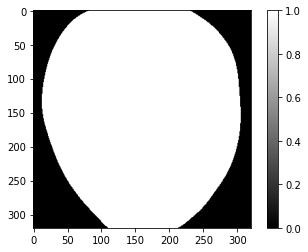

In [9]:
intersection_mask = CS_bitmask & sense_bitmask
plt.imshow(intersection_mask[slice], cmap='gray')
plt.colorbar()


In [10]:
def nmse_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return nmse(gt,pred)

def psnr_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return psnr(gt,pred)

def ssim_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return ssim(gt,pred)

def vgg_loss_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return vgg_loss(gt,pred)

def stacked_svd_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return stacked_svd(gt,pred)


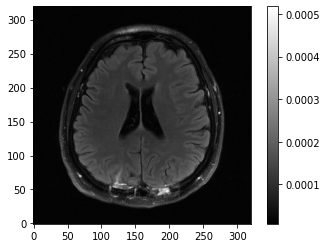

In [11]:
# GT
fig, ax = plt.subplots()
im = ax.imshow(GT[slice], cmap='gray', origin='lower')
plt.colorbar(im, ax=ax)
plt.show()


In [12]:
vmin, vmax = im.get_clim()


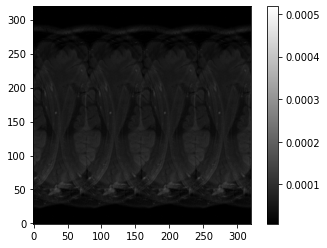

In [12]:
# ZF without ACS
plt.imshow(reconstruction_ZF_noACS[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


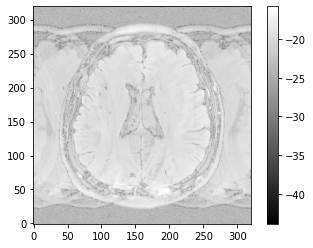

In [13]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF_noACS[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [14]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_noACS)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_noACS)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_noACS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_noACS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_noACS)}')


NMSE: 0.3655144789756222
PSNR: 25.100553162265054
SSIM: [0.66812083]
VGG: 0.10819961130619049
SVD: 0.28515625


In [15]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')


NMSE: 0.32577264862075483
PSNR: 25.68661292514551
SSIM: [0.75834482]
VGG: 0.10856696963310242
SVD: 0.2666015625


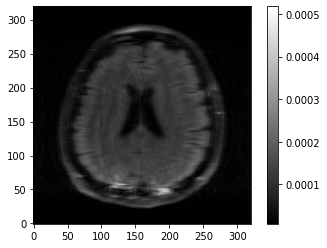

In [16]:
# ZF
plt.imshow(reconstruction_ZF[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


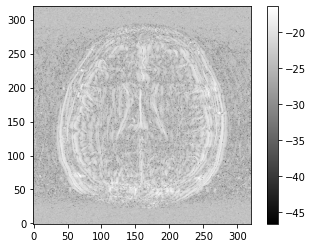

In [17]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [18]:
print(f'NMSE: {nmse(GT,reconstruction_ZF)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF)}')


NMSE: 0.036403010433174086
PSNR: 35.118236324244585
SSIM: [0.86108142]
VGG: 0.09094616025686264
SVD: 0.33203125


In [19]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF,intersection_mask)}')


NMSE: 0.03316293645223873
PSNR: 35.609232785280476
SSIM: [0.90705866]
VGG: 0.0951244980096817
SVD: 0.3001953125


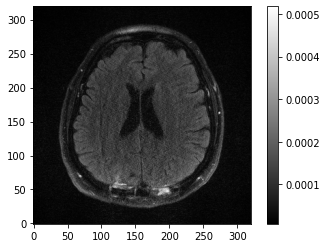

In [20]:
# Grappa
plt.imshow(reconstruction_grappa[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


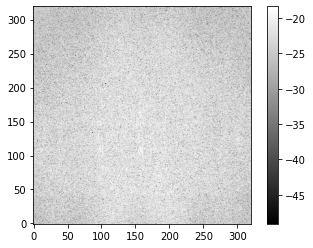

In [21]:
plt.imshow(np.log((GT[slice]-reconstruction_grappa[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [22]:
print(f'NMSE: {nmse(GT,reconstruction_grappa)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa)}')


NMSE: 0.03296174617036543
PSNR: 35.54947885426597
SSIM: [0.8562747]
VGG: 0.05514457821846008
SVD: 0.4537109375


In [23]:
print(f'NMSE: {nmse_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_grappa,intersection_mask)}')


NMSE: 0.029854757190508105
PSNR: 36.06562888348167
SSIM: [0.8870649]
VGG: 0.055690765380859375
SVD: 0.4013671875


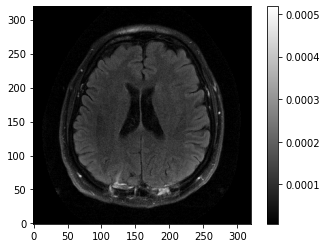

In [24]:
# Sense
plt.imshow(reconstruction_sense[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


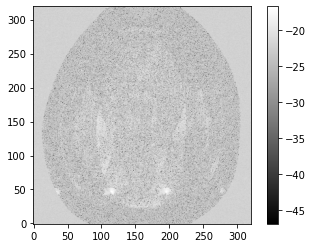

In [25]:
plt.imshow(np.log((GT[slice]-reconstruction_sense[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [26]:
print(f'NMSE: {nmse(GT,reconstruction_sense)}')
print(f'PSNR: {psnr(GT,reconstruction_sense)}')
print(f'SSIM: {ssim(GT,reconstruction_sense)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense)}')


NMSE: 0.03365716923065402
PSNR: 35.45884888064249
SSIM: [0.6356931]
VGG: 0.03300836309790611
SVD: 0.5828125


In [27]:
print(f'NMSE: {nmse_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_sense,intersection_mask)}')


NMSE: 0.014298073473685967
PSNR: 39.2629961922182
SSIM: [0.93791426]
VGG: 0.02820800431072712
SVD: 0.4357421875


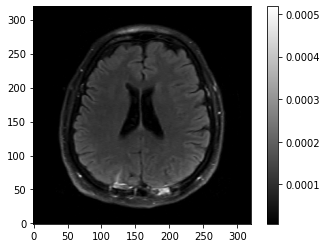

In [28]:
# CS
plt.imshow(reconstruction_CS[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


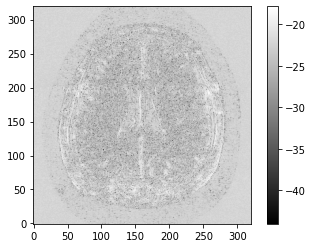

In [29]:
plt.imshow(np.log((GT[slice]-reconstruction_CS[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [30]:
print(f'NMSE: {nmse(GT,reconstruction_CS)}')
print(f'PSNR: {psnr(GT,reconstruction_CS)}')
print(f'SSIM: {ssim(GT,reconstruction_CS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_CS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_CS)}')


NMSE: 0.03511624472613696
PSNR: 35.27454360267646
SSIM: [0.59981263]
VGG: 0.039584968239068985
SVD: 0.546875


In [31]:
print(f'NMSE: {nmse_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_CS,intersection_mask)}')


NMSE: 0.01650329725793076
PSNR: 38.64006109952064
SSIM: [0.89294714]
VGG: 0.04458105191588402
SVD: 0.4099609375


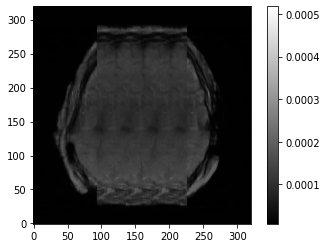

In [13]:
# ZF UNet without ACS
plt.imshow(reconstruction_ZF_unet_noACS[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


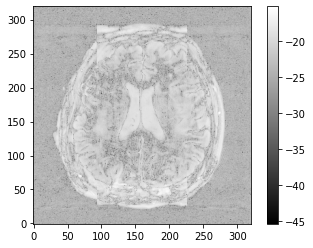

In [14]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF_unet_noACS[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [15]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_unet_noACS)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_unet_noACS)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_unet_noACS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_unet_noACS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_unet_noACS)}')


NMSE: 0.09986897432469782
PSNR: 30.73514540054214
SSIM: [0.86026259]
VGG: 0.09905414283275604
SVD: 0.253125


In [16]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')


NMSE: 0.10100274981786715
PSNR: 30.77239334834454
SSIM: [0.86832277]
VGG: 0.10000238567590714
SVD: 0.24921875


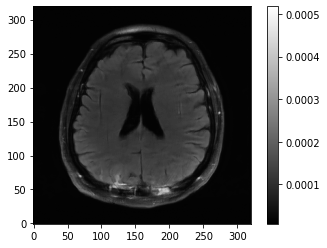

In [32]:
# ZF UNet
plt.imshow(reconstruction_ZF_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


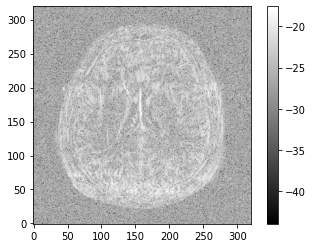

In [33]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [34]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_unet)}')


NMSE: 0.014410028266117961
PSNR: 39.142905190642935
SSIM: [0.95319461]
VGG: 0.045536648482084274
SVD: 0.345703125


In [35]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF_unet,intersection_mask)}')


NMSE: 0.014082729773657213
PSNR: 39.32887989375152
SSIM: [0.95865483]
VGG: 0.04663363844156265
SVD: 0.3208984375


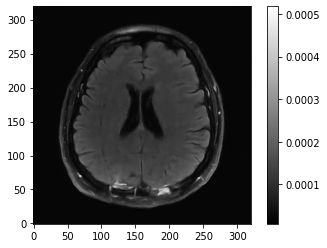

In [36]:
# Grappa UNet
plt.imshow(reconstruction_grappa_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


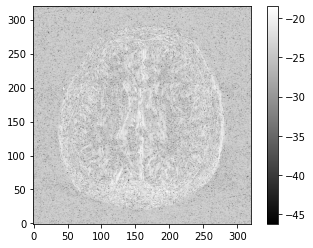

In [37]:
plt.imshow(np.log((GT[slice]-reconstruction_grappa_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [38]:
print(f'NMSE: {nmse(GT,reconstruction_grappa_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa_unet)}')


NMSE: 0.015312946839905516
PSNR: 38.87902642988991
SSIM: [0.93564858]
VGG: 0.042104512453079224
SVD: 0.44921875


In [39]:
print(f'NMSE: {nmse_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_grappa_unet,intersection_mask)}')


NMSE: 0.012275144892181206
PSNR: 39.92550271785674
SSIM: [0.95590644]
VGG: 0.045759011059999466
SVD: 0.3748046875


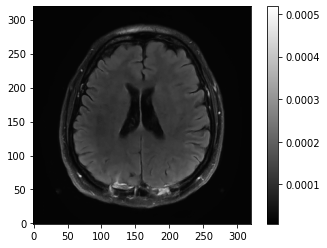

In [40]:
# Sense UNet
plt.imshow(reconstruction_sense_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


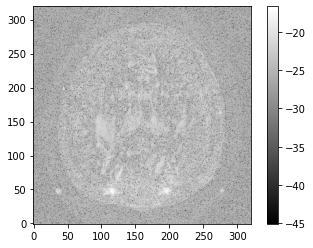

In [41]:
plt.imshow(np.log((GT[slice]-reconstruction_sense_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [42]:
print(f'NMSE: {nmse(GT,reconstruction_sense_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_sense_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_sense_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense_unet)}')


NMSE: 0.0076881588870017755
PSNR: 41.87135671133192
SSIM: [0.97112895]
VGG: 0.027946438640356064
SVD: 0.390234375


In [43]:
print(f'NMSE: {nmse_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_sense_unet,intersection_mask)}')


NMSE: 0.007258323366440257
PSNR: 42.20739795945648
SSIM: [0.97615013]
VGG: 0.028193380683660507
SVD: 0.349609375


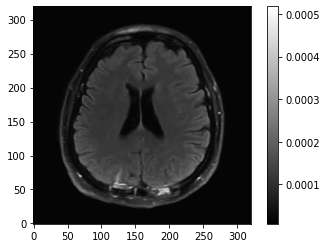

In [44]:
# CS UNet
plt.imshow(reconstruction_cs_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


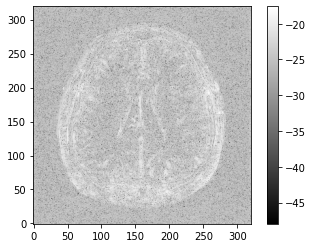

In [45]:
plt.imshow(np.log((GT[slice]-reconstruction_cs_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [46]:
print(f'NMSE: {nmse(GT,reconstruction_cs_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_cs_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_cs_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_cs_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_cs_unet)}')


NMSE: 0.012656642218307208
PSNR: 39.70639548098053
SSIM: [0.95501629]
VGG: 0.04408818483352661
SVD: 0.360546875


In [47]:
print(f'NMSE: {nmse_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_cs_unet,intersection_mask)}')


NMSE: 0.011901410986693308
PSNR: 40.059775832087155
SSIM: [0.96280626]
VGG: 0.045695576816797256
SVD: 0.3326171875
